# Explore here

**Imports**

In [16]:
import requests
import pandas as pd
from io import StringIO
import time 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest, chi2

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score


Vamos a cargar los datos

In [2]:
url="https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv"

data=pd.read_csv(url)
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Analizamos el tipo de datos, nulos y duplicados:**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Variables categóricas:
* sex
* smoker
* region

Variables numéricas:
* age
* bmi
* children
* charges (variable objetivo)

Ninguna de ellas tiene nulos, vamos a ver los duplicados:

In [4]:
print(f"El número de duplicados es: {data.duplicated().sum()}")
print(f"El % de nulos es:\n {data.isnull().sum()/len(data)*100}")


El número de duplicados es: 1
El % de nulos es:
 age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64


In [5]:
#Eliminamos los duplicados
data.drop_duplicates(inplace=True)
print(f"El número de duplicados es: {data.duplicated().sum()}")

El número de duplicados es: 0


**Vamos a analizar las variables numéricas y categóricas**

In [6]:
num_vars=["age","bmi","children"]
y="charges"
cat_vars=["sex","smoker","region"]
cat_vars_trans=["sex_n","smoker_n","region_n"]


#Factorizamos las variables categóricas
data[cat_vars_trans] = data[cat_vars].apply(lambda x: pd.factorize(x)[0])
data.head()

data_n=data.drop(cat_vars,axis=1,inplace=False)
data_n.head()

,age,bmi,children,charges,sex_n,smoker_n,region_n
0,19,27.900,0,16884.92400,0,0,0
1,18,33.770,1,1725.55230,1,1,1
2,28,33.000,3,4449.46200,1,1,1
3,33,22.705,0,21984.47061,1,1,2
4,32,28.880,0,3866.85520,1,1,2


**Analisis de variables categóricas:** 

En este caso, la variable objetivo es una variable continua, por tanto, podríamos analizar los datos por grupos de esas categóricas.

<Axes: xlabel='smoker', ylabel='charges'>

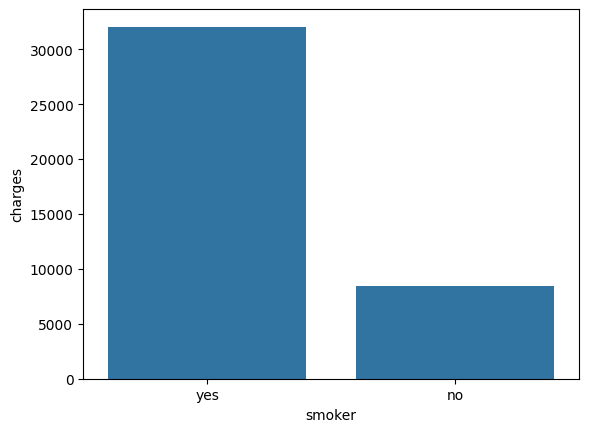

In [7]:
a=data.groupby(cat_vars[1])["charges"].mean().sort_values(ascending=False)
b=pd.DataFrame(a)
sns.barplot(data=b,x=b.index,y="charges")


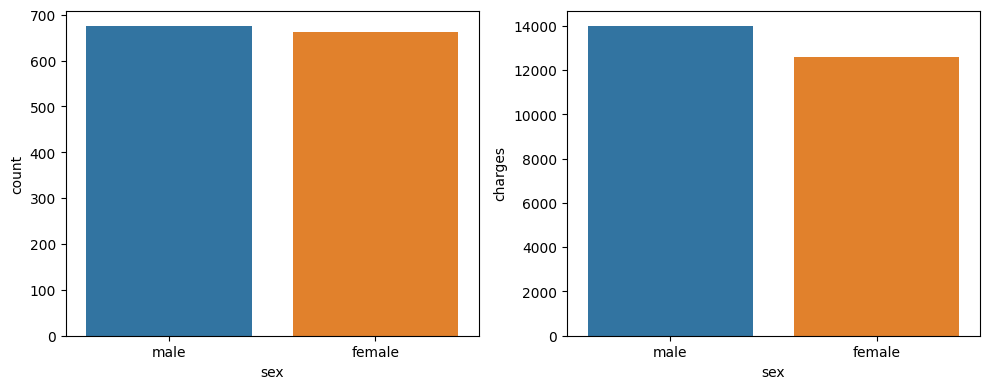

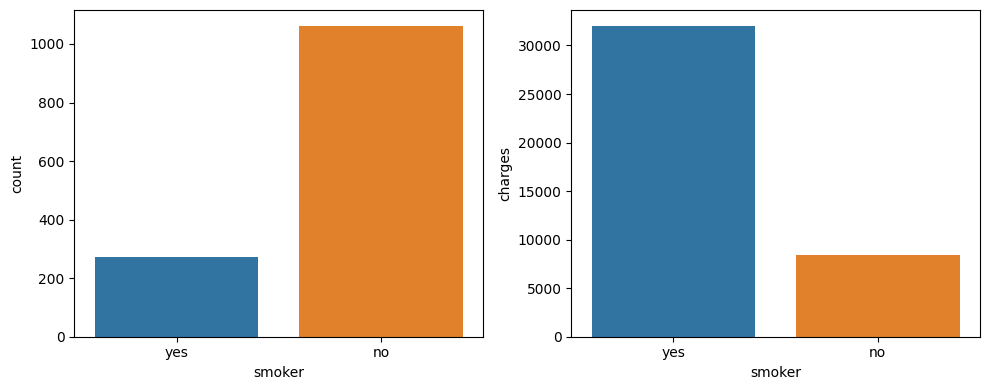

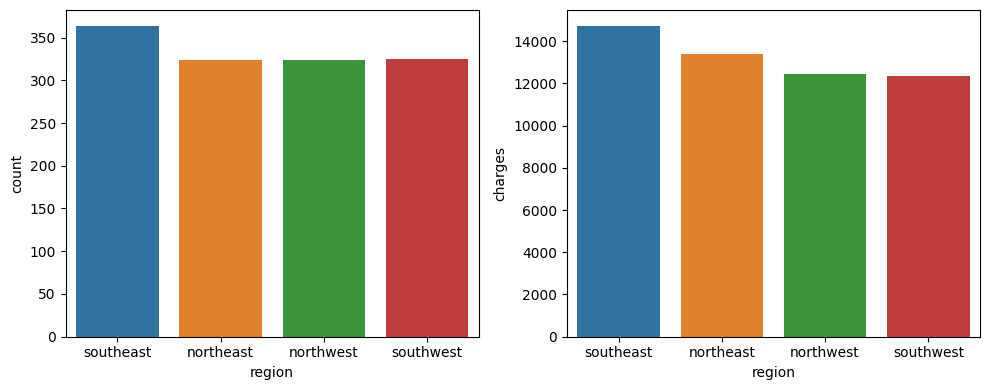

In [8]:
#fig, axis=plt.subplots(2,2)
#sns.boxplot(x=data["charges"],ax=axis[0,0])
for i in range(len(cat_vars)):
    fig, axis=plt.subplots(1,2,figsize=(10,4))
    means=data.groupby(cat_vars[i])["charges"].mean().sort_values(ascending=False)
    meansDF=pd.DataFrame(means)
    sns.countplot(data=data,x=cat_vars[i],hue=cat_vars[i],ax=axis[0],order=means.index,hue_order=means.index)
    sns.barplot(data=meansDF,x=meansDF.index,y="charges",ax=axis[1],hue=meansDF.index,hue_order=means.index)
    plt.tight_layout()
    plt.show()


#plot.set_xticklabels(plot.get_xticklabels(),rotation=45)


* **Smoker:** Se ve una clara relación entre la variable charges y smoker, siendo mucho más alta la cuota en fumadores que en no fumadores. 
* **Sex:** Hay una pequeña diferencia entre la cuota del hombre y la mujer, siendo más alta en la del hombre.
* **Region:** Por regiones no hay demasiada diferencia, aunque observamos que es ligeramente superior en *southeast*


**Análisis de variables numéricas**



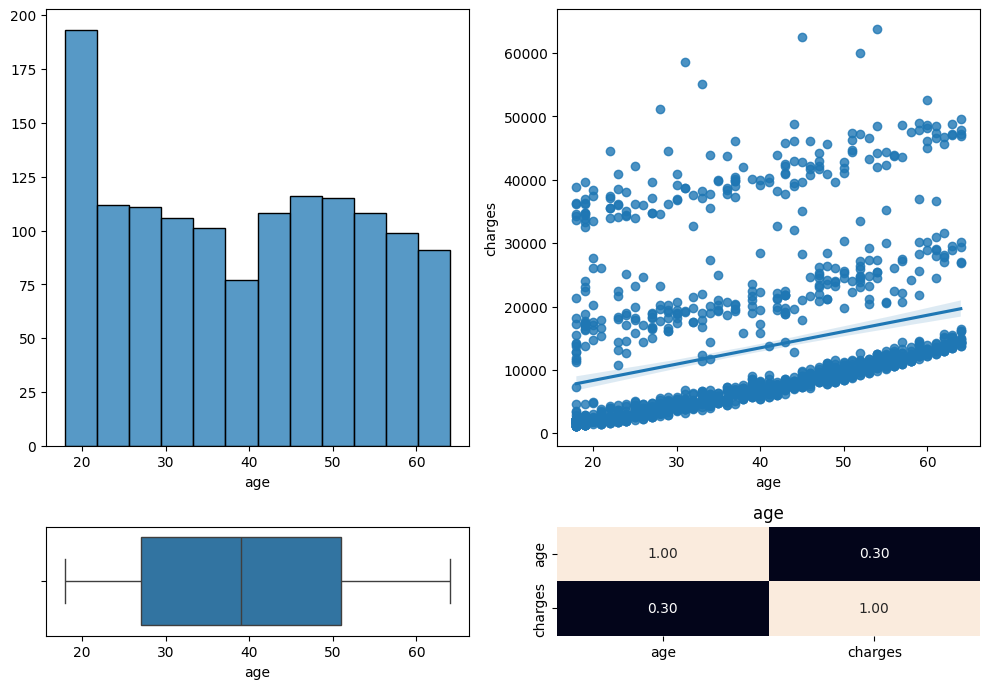

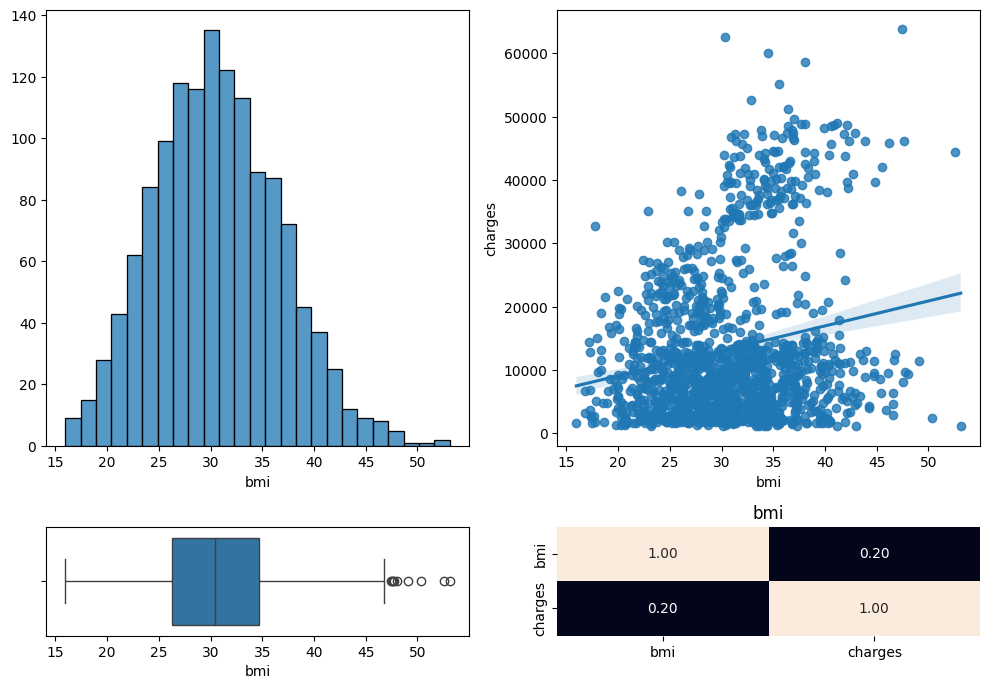

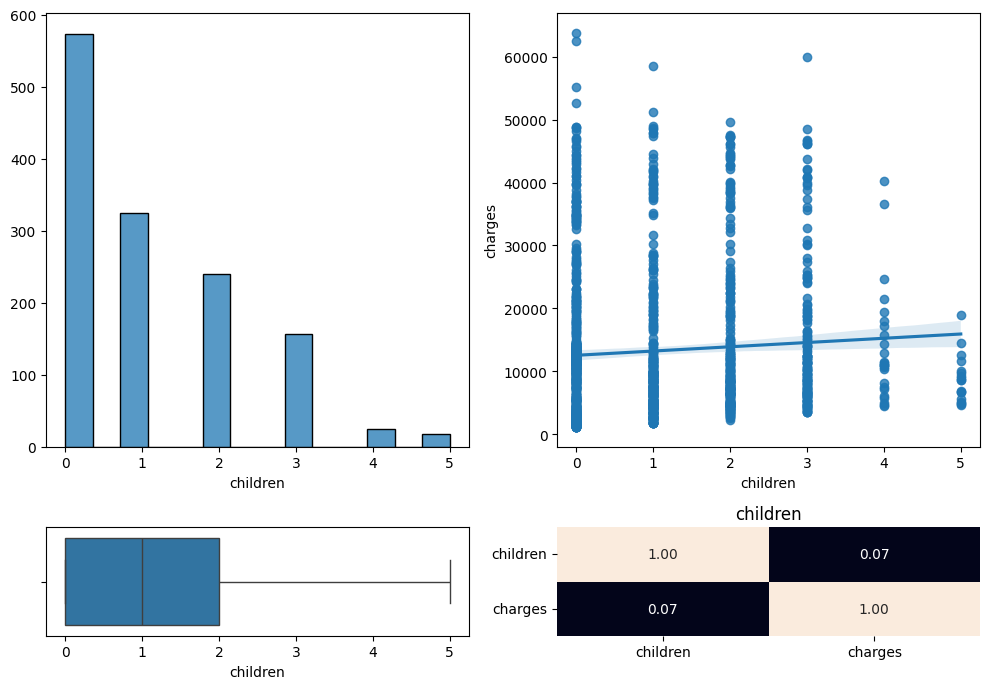

In [9]:
for i in range(len(num_vars)):
    fig, axis = plt.subplots(2, 2, figsize = (10,7),gridspec_kw={'height_ratios': [4, 1]})
    var=num_vars[i]
    sns.histplot(ax = axis[0,0], data = data, x = var).set(ylabel = None)
    plt.title(var)
    sns.boxplot(ax = axis[1,0], data = data, x = var)
    sns.regplot(data = data, x = var, y = "charges",ax=axis[0,1])
    sns.heatmap(data[[var, "charges"]].corr(), annot = True, fmt = ".2f", cbar = False,ax=axis[1,1])
    plt.tight_layout()
    plt.show()

* **Age:** En la edad vemos una correlación de 0.3 positiva, y en la gráfica observamos que sí que existe una relación entre la cuota y la edad.
* **Bmi:** En el bmi también vemos una relación, aunque menor que en la edad.
* **Children:** No se aprecia una relación, pero como la variable es discreta y bastante acotada en número, vamos a ver por medias como en el caso de las categóricas a ver los resultados.

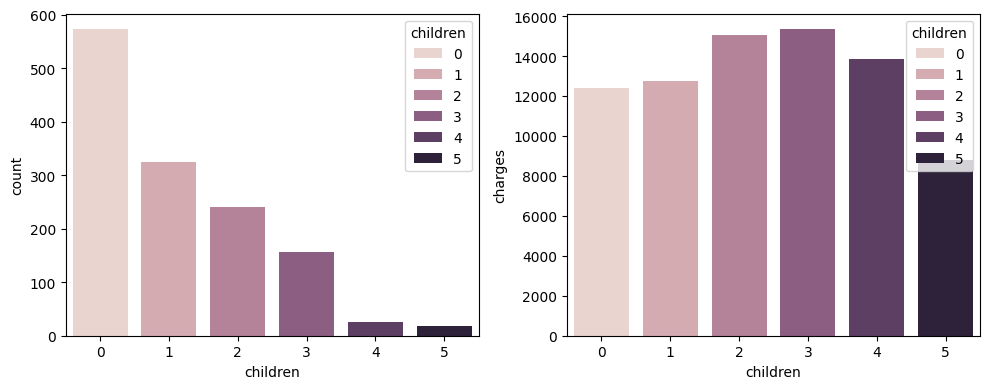

In [10]:
fig, axis=plt.subplots(1,2,figsize=(10,4))
means=data.groupby("children")["charges"].mean().sort_values(ascending=False)
meansDF=pd.DataFrame(means)
sns.countplot(data=data,x="children",hue="children",ax=axis[0],hue_order=means.index)
sns.barplot(data=meansDF,x=meansDF.index,y="charges",ax=axis[1],hue=meansDF.index,hue_order=means.index)
plt.tight_layout()
plt.show()

Con estos gráficos vemos muy bien que no existe tal relación, ya que aumenta hasta 3 hijos pero luego vuelve a bajar en 4 y 5 hijos.

Por último, echemos un vistazo a la matriz de correlaciones:

<Axes: >

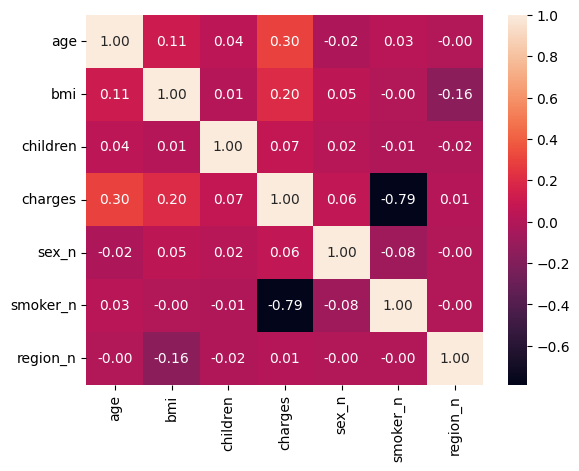

In [11]:
sns.heatmap(data_n.corr(), annot = True, fmt = ".2f")

Con estos datos, podemos realizar el modelo con las siguientes variables (en orden):
* Smoker
* Age
* Bmi

Y si queremos probar para ver si mejora el modelo, ya que son pocas variables:
* Sex 
* Region

Primero separamos las muestras de entrenamiento y test

In [12]:
X=data_n.drop("charges",axis=1,inplace=False)
y=data_n["charges"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

print(X_train.head())
print(X_test.head())


      age     bmi  children  sex_n  smoker_n  region_n
1114   23  24.510         0      1         1         3
968    21  25.745         2      1         1         3
599    52  37.525         2      0         1         2
170    63  41.470         0      1         1         1
275    47  26.600         2      0         1         3
      age     bmi  children  sex_n  smoker_n  region_n
900    49  22.515         0      1         1         3
1064   29  25.600         4      0         1         0
1256   51  36.385         3      0         1         2
298    31  34.390         3      1         0         2
237    31  38.390         2      1         1         1


Normalizamos los datos

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)

cols=data_n.columns.drop("charges")
X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = cols)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = cols)

print(round(X_train_norm.describe(),2))
print(round(X_test_norm.describe(),2))

           age      bmi  children    sex_n  smoker_n  region_n
count  1069.00  1069.00   1069.00  1069.00    1069.0   1069.00
mean      0.00     0.00      0.00     0.00      -0.0     -0.00
std       1.00     1.00      1.00     1.00       1.0      1.00
min      -1.52    -2.41     -0.91    -1.03      -2.0     -1.33
25%      -0.87    -0.72     -0.91    -1.03       0.5     -0.43
50%      -0.01    -0.06     -0.07     0.97       0.5     -0.43
75%       0.84     0.64      0.77     0.97       0.5      0.48
max       1.77     3.73      3.28     0.97       0.5      1.38
          age     bmi  children   sex_n  smoker_n  region_n
count  268.00  268.00    268.00  268.00    268.00    268.00
mean     0.01    0.10      0.05   -0.10     -0.06      0.05
std      1.02    1.04      1.05    1.00      1.04      1.01
min     -1.52   -2.27     -0.91   -1.03     -2.00     -1.33
25%     -0.96   -0.62     -0.91   -1.03      0.50     -0.43
50%      0.06    0.09     -0.07   -1.03      0.50     -0.43
75%      0.84

Seleccionamos las variables:

In [39]:
group_var1=["smoker_n","age","bmi"]
group_var2=["smoker_n","age","bmi","sex_n"]
group_var3=["smoker_n","age","bmi","sex_n","region_n"]
group_var5=["smoker_n","age","bmi","sex_n","children"]
group_var6=["smoker_n","age","bmi","region_n","children"]

In [40]:
model1 = LinearRegression()
model1.fit(X_train_norm[group_var1], y_train)
y_pred1 = model1.predict(X_test_norm[group_var1])

MSE1=mean_squared_error(y_test, y_pred1)
R21=r2_score(y_test, y_pred1)

model2 = LinearRegression()
model2.fit(X_train_norm[group_var2], y_train)
y_pred2 = model2.predict(X_test_norm[group_var2])


MSE2=mean_squared_error(y_test, y_pred2)
R22=r2_score(y_test, y_pred2)

model3 = LinearRegression()
model3.fit(X_train_norm[group_var3], y_train)
y_pred3 = model3.predict(X_test_norm[group_var3])

MSE3=mean_squared_error(y_test, y_pred3)
R23=r2_score(y_test, y_pred3)

model4 = LinearRegression()
model4.fit(X_train_norm, y_train)
y_pred4 = model4.predict(X_test_norm)

MSE4=mean_squared_error(y_test, y_pred4)
R24=r2_score(y_test, y_pred4)

model5 = LinearRegression()
model5.fit(X_train_norm[group_var5], y_train)
y_pred5 = model5.predict(X_test_norm[group_var5])

MSE5=mean_squared_error(y_test, y_pred5)
R25=r2_score(y_test, y_pred5)

model6 = LinearRegression()
model6.fit(X_train_norm[group_var6], y_train)
y_pred6 = model6.predict(X_test_norm[group_var6])

MSE6=mean_squared_error(y_test, y_pred6)
R26=r2_score(y_test, y_pred6)

nombres=["Sm,Ag,Bm","Sm,Ag,Bm,Sx","Sm,Ag,Bm,Sx,Rg","Sm,Ag,Bm,Sx,Ch","Sm,Ag,Bm,Ch,Rg","Todas"]
dic={
    "MSE":[round(MSE1,2),round(MSE2,2),round(MSE3,2),round(MSE5,2),round(MSE6,2),round(MSE4)],
    "R2":[R21,R22,R23,R25,R26,R24]
}

comparativa=pd.DataFrame(dic)
comparativa.index=nombres
print(comparativa)

                        MSE        R2
Sm,Ag,Bm        35841574.82  0.804950
Sm,Ag,Bm,Sx     35833764.89  0.804993
Sm,Ag,Bm,Sx,Rg  35465218.94  0.806998
Sm,Ag,Bm,Sx,Ch  35901914.11  0.804622
Sm,Ag,Bm,Ch,Rg  35506758.21  0.806772
Todas           35493103.00  0.806847


Según las variables escogidas, la mejor opción es el modelo con las siguientes variables:
* Smoker
* Age
* Bmi
* Sex
* Region

Arrojando un R2 de 0.8069
